In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from astropy.units import jupiterMass, jupiterRad, a, day, earthRad, earthMass, solMass, solRad, AU
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler_norm = MinMaxScaler()
scaler_stnd = StandardScaler()

# File 1: reading file and first clustering: mass vs orbital period

Steps for reading data:
* Picking what parameters to keep for a specific test.
* Removing Nans, by removing from the dataframe planets that contain it for the chosen parameters.
* Standardizing data: Our variables are measured at different scales, so they won't contribute equally to the analysis. 

In [3]:
file_US="/home/bolacha/University/Project/code/data-example/all_data_US.rdb"
file_EU="/home/bolacha/University/Project/code/data-example/all_data_EU.rdb"
cat_solar="/home/bolacha/University/Project/code/data-example/solar_data.csv"

In [8]:
def read_file(file, params=0, removeNaN=True):
    database = np.genfromtxt(file, comments="--", skip_header=4,
                            dtype=None, delimiter="\t", encoding=None)
    df_exo = pd.DataFrame(database)
    with open(file) as f:
        columns = f.readline()
    columns = columns.replace("\n", "")
    columns = columns.split('\t')
    df_exo.columns = columns
    df_exo = pd.DataFrame.set_index(df_exo,keys='obj_id_catname')
    if params != 0:
        df_exo = df_exo[params]
    if removeNaN == True:
        df_exo = pd.DataFrame.dropna(df_exo,axis=0, how='any')
    return df_exo

def sol_pd(params, file=cat_solar):
    solar=pd.DataFrame.transpose(pd.read_csv(cat_solar, index_col=0))
    solar['temp_eq'] = solar.T_C+274.15
    solar['obj_phys_mass_mjup'] = solar.M*earthMass.to(jupiterMass)
    solar['obj_phys_radius_rjup'] = solar.D/2*earthRad.to(jupiterRad)
    solar['obj_orb_period_day'] = solar.P*a.to(day)
    solar['obj_orb_ecc'] = solar.e*0.0167
    solar['obj_orb_a_au'] = solar.a
    solar['obj_parent_phys_teff_k'] = np.ones(len(solar))*5778
    solar = solar[params]
    return solar

def exo_sol(file_exo,params,stnd=False,norm=False):
    df_solar = sol_pd(params)
    df_exo = read_file(file_exo,params)
    data = pd.concat([df_exo,df_solar])
    if stnd == True:
        data = scaler_stnd.fit_transform(data)
    if norm == True:
        data = scaler_norm.fit_transform(data)
    return data

def split(data):
    train, test = train_test_split(data,test_size=.2,train_size=.8)
    return train, test

In [17]:
#d_US_test = read_file(file_US)
#d_US_test.columns

In [18]:
param_MP=['obj_orb_period_day','obj_phys_mass_mjup']
#for the first clustering trial -- mass vs orbital period

d_EU_MP, d_solar = read_file(file_EU,param_MP), sol_pd(param_MP)
d_US_MP = read_file(file_US,param_MP)
data_MP = exo_sol(file_US,param_MP)

M_EU_MP, P_EU_MP = d_EU_MP['obj_phys_mass_mjup'], d_EU_MP['obj_orb_period_day']
M_US_MP, P_US_MP = d_US_MP['obj_phys_mass_mjup'], d_US_MP['obj_orb_period_day']
M_solar, P_solar=d_solar['obj_phys_mass_mjup'], d_solar['obj_orb_period_day']
#len(data_MP)

We first aim to find three separate groups:
* Hot jupiters: P $\lesssim 7$ d, $M/M_J \leq 12$; centered around $\sim 1 M_J$ and $P \sim 3$ d; 
* Eccentric giants: $10^2 d \lesssim P \lesssim 10^4 d$; $1 \lesssim M/M_J \leq 10$.
* Ungiants: $P \leq 100 d$; $ M/M_J \lesssim 0.07$ and $R \lesssim 0.35 R_J$

$\rightarrow$ <u>Task 1:</u>  mass vs period.

# mass vs orbital period

In [19]:
N = [1,2,5] #index of solar planets i'll distinguish on the plot
planet_name, planet_color = ['V','E','J'], ['purple','tab:green','tab:red']
d=[-100,100,1600] #this helps put the labels in the right place

#plt.scatter(P_solar, M_solar, label = "Solar planets",c='gray',s=20)
#plt.scatter(P_EU_MP, M_EU_MP, label = "Exoplanet.eu",c='b',s=20)
#plt.scatter(P_US_MP, M_US_MP, label= "NASA Archive",c='c',s=20)
#for i,n in enumerate(N):
#    plt.scatter(P_solar[n],M_solar[n],c=planet_color[i])
#    plt.annotate(planet_name[i],(P_solar[n]+d[i],M_solar[n]),c=planet_color[i])

#plt.ylabel(r"$M/M_J$ - log scale")
#plt.yscale('log')
#plt.xscale('log')
#plt.xlabel(r"$P (days)$ - log scale")
#plt.ylim(12e-5,15e1)
#plt.xlim(15e-3,10e5)
#plt.legend(loc='lower right')
#plt.title(r"Mass-Period")
#plt.show()

Which is a first visualization for the relationship between orbital period and mass, in the full range we're studying, and also reproduces the figure in my document.

We can already see the three separate groups.

Testing on train/test data

In [125]:
train, test = split(data_MP)
print(len(train),len(test))

1183 296


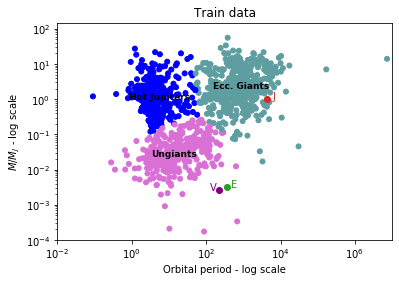

In [101]:
M_train,  P_train = train['obj_phys_mass_mjup'], train['obj_orb_period_day']
M,P = test['obj_phys_mass_mjup'], test['obj_orb_period_day']
kmeans = KMeans(n_clusters=3,init='k-means++',max_iter=300, tol=0.0001).fit(np.log(train))
centroids, labels = kmeans.cluster_centers_, kmeans.labels_

N = [1,2,5]

colors, group_names = ['cadetblue','b','orchid'], ['Ecc. Giants','Hot Jupiters','Ungiants']
label_color, label_names = [], []
for l in labels:
    label_color = np.append(label_color, colors[l])
    label_names = np.append(label_names, group_names[l])
    
plt.scatter(P_train,M_train,c=label_color,s=25)
for i, n in enumerate(N):
    plt.scatter(P_solar[n],M_solar[n],c=planet_color[i])
    plt.annotate(planet_name[i],(P_solar[n]+d[i],M_solar[n]),c=planet_color[i]) 
    plt.annotate(group_names[i],(np.exp(centroids[:,0][i]-1.6),np.exp(centroids[:,1][i]-.1)),c='k',weight='bold',size=9)
plt.xlabel('Orbital period - log scale')
plt.ylabel(r'$M/M_J$ - log scale')
plt.yscale('log')
plt.xscale('log')
plt.title("Train data")
plt.ylim(10e-5,15e1)
plt.xlim(10e-3,10e6)
plt.show()

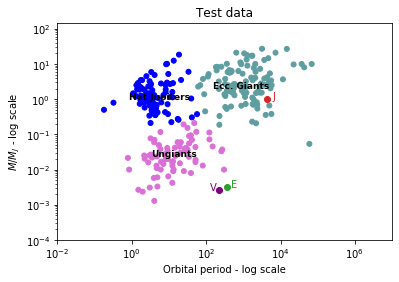

In [102]:
#applying resulton test data
result = kmeans.predict(np.log(test))
result_list, result_names = [], []
for l in result:
    result_list = np.append(result_list, colors[l])
    result_names = np.append(result_names, group_names[l])

    
plt.scatter(P,M,c=result_list,s=25)
for i, n in enumerate(N):
    plt.scatter(P_solar[n],M_solar[n],c=planet_color[i])
    plt.annotate(planet_name[i],(P_solar[n]+d[i],M_solar[n]),c=planet_color[i]) 
    plt.annotate(group_names[i],(np.exp(centroids[:,0][i]-1.6),np.exp(centroids[:,1][i]-.1)),c='k',weight='bold',size=9)
plt.xlabel('Orbital period - log scale')
plt.ylabel(r'$M/M_J$ - log scale')
plt.yscale('log')
plt.xscale('log')
plt.ylim(10e-5,15e1)
plt.title("Test data")
plt.xlim(10e-3,10e6)
plt.show()

In [134]:
train=train[['obj_orb_period_day','obj_phys_mass_mjup']]
test=test[['obj_orb_period_day','obj_phys_mass_mjup']]

In [137]:
pd_labels, pd_names = pd.DataFrame(labels,index=train.index), pd.DataFrame(label_names,index=train.index),
test_labels, test_names = pd.DataFrame(result,index=test.index), pd.DataFrame(result_names,index=test.index),

train['labels'], train['names']= pd_labels, pd_names
test['labels'], test['names'] = test_labels, test_names